In [12]:
import sys
sys.path.append('../utils/bbox')

from pathlib import Path
import os
import glob
import pickle as pk
import numpy as np
import numpy.matlib as npm
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image, ImageDraw
from scipy import spatial as sps
from scipy.ndimage import center_of_mass
import scipy.ndimage
import scipy as sp
from bbox.min_bounding_rect import minBoundingRect
import matplotlib.patches as patches

#np.set_printoptions(threshold=sys.maxsize)

def process_hail(
    gsd, Lmin, path_pkl, orthophoto_file, path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
    save_hail_tmp=1, file_masks=None, use_shape_factor=False, overplot_ortho=False, out_file_CNN=None
):
    """
    Process hail data from detected masks of image tiles from the orthophoto.

    Parameters:
    - gsd (float): Ground sampling distance in millimeters per pixel.
    - Lmin (int): Minimum lightness value of the center hail pixel for classification.
    - path_pkl (str): Path to the directory containing pickle files with detected hail masks.
    - orthophoto_file (str): Path to the orthophoto image file.
    - path_detection_edge (str): Path to save the edge detection visualizations.
    - path_detection_mask (str): Path to save the mask detection visualizations.
    - path_rgb_img (str): Path to save the RGB image visualizations.
    - hd_out_path (str): Path to save the processed hail dictionary.
    - save_hail_tmp (int, optional): Save temporary hail dictionary flag (default is 1).
    - file_masks (str, optional): Path to save the file containing all hail masks (default is None).
    - use_shape_factor (bool, optional): Flag to use shape factor for filtering hailstones (default is False).
    - overplot_ortho (bool, optional): Flag to overplot orthophoto image with detected hailstones (default is False).
    - out_file_CNN (str, optional): If overplot_ortho (True) then this is the name of the output image (default is False).

    Returns:
    dict: Hail dictionary containing processed information about detected hailstones.
    The dictionary includes the following keys:
    - 'hail_co': Global coordinates of hailstones in orthophoto.
    - 'tile_names': Names of tiles corresponding to each hailstone.
    - 'tile_co': Coordinates of hailstones in their respective tiles.
    - 'major_ed': Sizes of major axes detected using edge detection.
    - 'minor_ed': Sizes of minor axes detected using edge detection.
    - 'major_ma': Sizes of major axes using mask information.
    - 'minor_ma': Sizes of minor axes using mask information.
    - 'L_center': Lightness values of center hail pixels.
    - 'edge_co': Coordinates of detected hail edges.
    - 'img': Cropped images around hailstones.
    - 'img_mask_sect': Cropped mask sections around hailstones.

    Note:
    - The function processes detected hail masks and extracts relevant information about hailstones.
    - Visualizations are saved based on the provided paths.
    - The processed hail dictionary is saved as 'hail_dict.pkl' in the specified 'hd_out_path'.
    """
    gsd=gsd
    
    if path_detection_edge != None:
        if not os.path.exists(path_detection_edge):
            os.makedirs(path_detection_edge)
    
    if not os.path.exists(path_detection_mask):
        os.makedirs(path_detection_mask)
    
    if not os.path.exists(path_rgb_img):
        os.makedirs(path_rgb_img)
    
    if not os.path.exists(hd_out_path):
        os.makedirs(hd_out_path)
    
    all_files = glob.glob(path_pkl+'*.pkl')
    all_files.sort()

    #Initialize hail dictionary for all relevant results
    hail_dict = {}
    
    #Initialize global coordinates of hail in orthophoto
    x_glob = []
    y_glob = []
    
    x_tile = []
    y_tile = []
    
    tile_names = []
    all_masks = []
    
    for file in all_files:
        filename = Path(file).stem
        tile_name = filename[11:]+'.png'
        
        #get tile row and column value
        t_row = np.int(filename[-5:-3])
        t_col = np.int(filename[-2:])
        
        with open(file,'rb') as f:
            masks = pk.load(f)
        
        for i in np.arange(0,np.shape(masks)[0]):
            #calculate center of gravity coordinates for every mask
            com = np.round(center_of_mass(masks[i]))

            if masks[i][np.int(com[0]),np.int(com[1])] != 1:
                print('Not a hail pixel')
            else:
                #x/y coordinates in tile (500x500)
                y0 = np.int(com[0])
                x0 = np.int(com[1])

                x_tile.append(x0)
                y_tile.append(y0)
                
                #x/y coordinates in global picture
                x_glob_tmp = x0 + (t_col*500)
                y_glob_tmp = y0 + (t_row*500)

                x_glob.append(x_glob_tmp)
                y_glob.append(y_glob_tmp)

                all_masks.append(masks[i])
                tile_names.append(tile_name)
    
    hail_coords = np.vstack((x_glob,y_glob))
    tile_coords = np.vstack((x_tile,y_tile))
    
    hail_dict['hail_co'] = hail_coords
    hail_dict['tile_names'] = tile_names
    hail_dict['tile_co'] = tile_coords
       
    if save_hail_tmp == 1:
        with open(hd_out_path+'hail_dict_tmp.pkl', 'wb') as f:
            pk.dump(hail_dict, f)
            
        with open(file_masks, 'wb') as f:
            pk.dump(all_masks, f)  
    
    #Load orthophoto image                             
    PIL.Image.MAX_IMAGE_PIXELS = 8046500000
    image = np.asarray(Image.open(orthophoto_file))

    hail_dict['gsd'] = gsd
        
    if overplot_ortho == True:   
        img_ortho = cv2.imread(orthophoto_file)
        overplot_center_hail_px(img_ortho,x_glob,y_glob,out_file_CNN)

    k=25 #Surrounding pixel size from center hail pixel to consider for edge detection
    
    hail_dict['major_ed'] = []
    hail_dict['minor_ed'] = []
    hail_dict['major_ma'] = []
    hail_dict['minor_ma'] = []
    hail_dict['L_center'] = []
    hail_dict['edge_co'] = []
    hail_dict['img'] = []
    hail_dict['img_mask_sect'] = []

    #Create ghost mask as big as zoom mask eg (50,50)
    empty_mask = np.zeros([2*k, 2*k], dtype=int)
    image_height = 2*k
    image_width = 2*k
    number_of_color_channels = 3
    color = (255,0,255)
    pixel_array = np.full((image_height, image_width, number_of_color_channels), color, dtype=np.uint8)
    
    for i,x in enumerate(hail_coords[0]):
        y = hail_coords[1][i]
        
        img = image[y-k:y+k, x-k:x+k,:]
        #print(np.shape(img))
        
        if np.size(img,0) == 0:
            print('Use dummy img!')
            img = pixel_array #Dummy image
            
        if np.size(img,1) == 0:
            print('Use dummy img!')
            img = pixel_array #Dummy image 

        if (y_tile[i] < k) and (x_tile[i] > k):
            print('y smaller than k!')
            print('x-co: ', x)
            print('y-co:', y)
            img_mask = empty_mask
            mask_sect = all_masks[i][0:y_tile[i]+k, x_tile[i]-k:x_tile[i]+k]
            img_mask[k-y_tile[i]:y_tile[i]+k*2, 0:np.size(mask_sect,1)] = mask_sect
        
        elif (x_tile[i] < k) and (y_tile[i] > k):
            print('x smaller than k!')
            print('x-co: ', x)
            print('y-co:', y)
            
            img_mask = empty_mask
            mask_sect = all_masks[i][y_tile[i]-k:y_tile[i]+k, 0:x_tile[i]+k]
            img_mask[0:np.size(mask_sect,0), k-x_tile[i]:x_tile[i]+k*2] = mask_sect
        
        elif (y_tile[i] < k) and (x_tile[i] < k):
            print('Both smaller than k!')
            print('x-co: ', x)
            print('y-co:', y)
            
            img_mask = empty_mask
            mask_sect = all_masks[i][0:y_tile[i]+k, 0:x_tile[i]+k]
            img_mask[-(np.size(mask_sect,0)):,-(np.size(mask_sect,1)):] = mask_sect
            
        elif (y_tile[i] > k) and (x_tile[i] > k):
            img_mask = empty_mask
            mask_sect = all_masks[i][y_tile[i]-k:y_tile[i]+k, x_tile[i]-k:x_tile[i]+k]
            #img_mask[k-y_tile[i]:y_tile[i]+k*2, k-x_tile[i]:x_tile[i]+k*2] = mask_sect
            img_mask[0:np.size(mask_sect,0), 0:np.size(mask_sect,1)] = mask_sect
        
        
        hail_dict['img'].append(img)
        hail_dict['img_mask_sect'].append(mask_sect)
        
        major_ax_tmp, minor_ax_tmp, major_ma_tmp, minor_ma_tmp, edge_x_tmp, edge_y_tmp, L_center = detect_hail_size(img, gsd, k, k, x, y,
                                                                              Lmin, mask=img_mask, path_detection_edge=path_detection_edge,
                                                                              path_detection_mask=path_detection_mask, path_rgb_img=path_rgb_img)
        
        if major_ax_tmp == None:
            continue
        else:
            if use_shape_factor == True:
                if major_ax_tmp/minor_ax_tmp >= 2:
                    print('Warning: Likely no hail due to wrong shape.')
                else:    
                    hail_dict['major_ed'].append(major_ax_tmp)
                    hail_dict['minor_ed'].append(minor_ax_tmp)
                    hail_dict['edge_co'].append(np.asarray([[edge_x_tmp], [edge_y_tmp]]))
                    hail_dict['L_center'].append(L_center)
            else:
                hail_dict['major_ed'].append(major_ax_tmp)
                hail_dict['minor_ed'].append(minor_ax_tmp)
                hail_dict['major_ma'].append(major_ma_tmp)
                hail_dict['minor_ma'].append(minor_ma_tmp)
                hail_dict['edge_co'].append(np.asarray([[edge_x_tmp], [edge_y_tmp]]))
                hail_dict['L_center'].append(L_center)

    with open(hd_out_path+'hail_dict.pkl', 'wb') as f:
        pk.dump(hail_dict, f)
     
    return hail_dict

def detect_hail_size(
    img, gsd, x0, y0, xglob, yglob, Lmin, mask=None, 
    path_detection_edge=None, path_detection_mask=None, path_rgb_img=None
):
    """
    Detect the size of hailstones in an image.

    Parameters:
    - img (numpy.ndarray): The RGB image containing hailstones.
    - gsd (float): The ground sampling distance in millimeters per pixel.
    - x0 (int): The x-coordinate of the center hail pixel.
    - y0 (int): The y-coordinate of the center hail pixel.
    - xglob (float): The global x-coordinate of the hailstone.
    - yglob (float): The global y-coordinate of the hailstone.
    - Lmin (int): The minimum lightness value of the center hail pixel for classification.
    - mask (numpy.ndarray, optional): Binary mask indicating regions of interest in the image.
    - path_detection_edge (str, optional): Path to save the edge detection visualization.
    - path_detection_mask (str, optional): Path to save the mask detection visualization.
    - path_rgb_img (str, optional): Path to save the RGB image visualization.

    Returns:
    Tuple: A tuple containing major_size, minor_size, major_size_ma, minor_size_ma, x, y, and L0.
    - major_size (float): Size of the major axis of hailstones in millimeters.
    - minor_size (float): Size of the minor axis of hailstones in millimeters.
    - major_size_ma (float): Size of the major axis of hailstones using mask information in millimeters.
    - minor_size_ma (float): Size of the minor axis of hailstones using mask information in millimeters.
    - x (float): X-coordinate of the detected hailstone.
    - y (float): Y-coordinate of the detected hailstone.
    - L0 (int): Lightness value of the center hail pixel.

    Note:
    The function also generates and saves visualizations if the optional paths are provided.
    """
    #Convert image into HLS space
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #filename = Path(file).stem
    
    #Lightness value of center hail pixel
    L0 = img_hls[x0,y0,1]
    L0 = np.int64(L0)
    
    #if L0 < Lmin:
    #    print('Warning: Center hail pixel lightness only '+str(L0)+'. Classified as no hail!')
    #    return None, None, None, None, None, None, L0
    
    major_size = 0
    minor_size = 0
    x = 0
    y = 0
    
    if path_detection_edge != None: 
        data = np.array(img_hls)
        origin=(x0,y0)
        polar_grid, rad, theta = reproject_image_into_polar(data, origin) 
        
        print(np.size(rad))
        #Initialize edge coordinates
        edge_co = []

        #radial_co = []
        #Loop over all theta angles [RAD]
        for t, th in enumerate(theta):
            grad_L = []
            L_ra0 = []

            #Loop along polar radial pixels
            for r, ra in enumerate(rad):
                #if (p[0] > np.size(img,0)) or (p[1] > np.size(img,1)) or (p[0] < 0) or (p[1] < 0):
                #    continue
                
                #Stop before image bounds are reached
                if r == np.size(rad)-1:
                    break
                
                L_ra0_tmp = polar_grid[r,t,1]
                L_ra0_tmp = np.int64(L_ra0_tmp)
                L_ra0.append(L_ra0_tmp)

                #Gradient to neighbor pixel
                L_ra1 = polar_grid[r+1,t,1]
                L_ra1 = np.int64(L_ra1)
                grad_L_tmp = np.gradient([L_ra0_tmp,L_ra1])
                grad_L.append(grad_L_tmp[0])

                if r == 0:
                    continue
                else:
                    if (np.abs(grad_L[r]) < 0.75 * np.abs(grad_L[r-1])) and (L0 - L_ra0_tmp > 50):

                        #for i in reversed(range(r+1)):
                        for i in reversed(np.arange(0,r+1)):
                            if (np.abs(grad_L[i-1]) < 0.75 * np.abs(grad_L[i])) and (L0 - L_ra0[i] < 50):

                                #Save polar coordinates when condition is true
                                edge_co_tmp = (rad[i], th)
                                #edge_co_tmp = (ra, th)

                                edge_co.append(edge_co_tmp)
                                break
                        break
                    else:
                        continue

        r_bt = np.array(edge_co)[:,0]
        th_bt = np.array(edge_co)[:,1]
        x,y = polar2cart(r_bt,th_bt)
        cart_co=[]
        for i, xval in enumerate(x):
            cart_co.append((xval+x0,y[i]+y0)) 

        (rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(cart_co))

        #Hail major axes and minor axes size from box
        major_size = np.max([width,height]) * gsd
        minor_size = np.min([width,height]) * gsd
    
    s = np.argwhere(mask == 1)
    
    if len(s) == 0:
        print(mask)
        major_size_ma = 0
        minor_size_ma = 0
    else:    
        (rot_angle_ma, area_ma, width_ma, height_ma, center_point_ma, box_ma) = minBoundingRect(np.fliplr(s))
        
        major_size_ma = np.max([width_ma,height_ma]) * gsd
        minor_size_ma = np.min([width_ma,height_ma]) * gsd

        if path_detection_mask != None:
            fig, ax = plt.subplots(figsize=[5,5])
            ax.plot(x0,y0,marker='x', color='red')
            plt.grid()
            
            mask_tmp = mask[0:np.size(img_hls,0), 0:np.size(img_hls,1)]
            
            img_hls_masked = np.ma.masked_array(img_hls[:,:,1], mask=mask_tmp)
            img_hls_masked_bg = np.ma.masked_array(img_hls[:,:,1], mask=np.where((mask_tmp==0)|(mask_tmp==1), mask_tmp^1, mask_tmp))
            
            plt.imshow(img_hls_masked, cmap='viridis', interpolation='none', alpha=0.5, norm=None, vmin=0, vmax=255)
            pos = plt.imshow(img_hls_masked_bg, cmap='viridis', interpolation='none', norm=None, vmin=0, vmax=255)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = fig.colorbar(pos, ax=ax, cax=cax)
            
            #plot bounding box:
            ax.plot([box_ma[0][0],box_ma[1][0]],[box_ma[0][1],box_ma[1][1]],color='red')
            ax.plot([box_ma[1][0],box_ma[2][0]],[box_ma[1][1],box_ma[2][1]],color='red')
            ax.plot([box_ma[2][0],box_ma[3][0]],[box_ma[2][1],box_ma[3][1]],color='red')
            ax.plot([box_ma[3][0],box_ma[0][0]],[box_ma[3][1],box_ma[0][1]],color='red')
            ax.set_title('Major axis = '+str(np.round(major_size_ma,2))+'mm, Minor axis = '+str(np.round(minor_size_ma,2))+'mm')

            #plt.xlabel('PX')
            plt.ylabel('Lightness value [DN]')
            plt.savefig(path_detection_mask+'hail_x'+str(np.int(xglob))+'_y'+str(np.int(yglob))+'_ma.png',dpi=300,bbox_inches='tight')
            plt.close()
    
    if path_detection_edge != None:
        fig, ax = plt.subplots(figsize=[5,5])
        plt.scatter((x+x0),(y+y0),s=2,c='black')
        ax.plot(x0,y0,marker='x', color='red')
        plt.grid()
        pos = plt.imshow(img_hls[:,:,1],cmap='viridis',interpolation='none', norm=None, vmin=0, vmax=255)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(pos, ax=ax, cax=cax)
        #cbar.set_label('Lightness value [DN]')
        
        #plot bounding box:
        ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
        ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
        ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
        ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
        ax.set_title('Major axis = '+str(np.round(major_size,2))+'mm, Minor axis = '+str(np.round(minor_size,2))+'mm')
        #plt.xlabel('PX')
        plt.ylabel('Lightness value [DN]')
        plt.savefig(path_detection_edge+'hail_x'+str(np.int(xglob))+'_y'+str(np.int(yglob))+'_ed.png',dpi=300,bbox_inches='tight')
        plt.close()
    
    if path_rgb_img !=None:
        fig, ax = plt.subplots(figsize=[5,5])
        ax.plot(x0,y0,marker='x', color='red')
        plt.grid()
        pos = plt.imshow(img)
        ax.set_title('RGB image of hailstone ('+str(np.int(xglob))+'|'+str(np.int(yglob))+')')
        #plt.xlabel('PX')
        #plt.ylabel('PX')
        plt.savefig(path_rgb_img+'hail_x'+str(np.int(xglob))+'_y'+str(np.int(yglob))+'_rgb.png',dpi=300,bbox_inches='tight')
        plt.close()
        
    return major_size, minor_size, major_size_ma, minor_size_ma, x , y, L0

def overplot_center_hail_px(image_cv, x_glob, y_glob, out_file):
    """
    Overplot the centers of hail masks on the original orthophoto image and save the result.

    Parameters:
    - image_cv (numpy.ndarray): The original orthophoto image in OpenCV format (BGR or RGB).
    - x_glob (numpy.ndarray): Array containing global x-coordinates of the hail mask centers.
    - y_glob (numpy.ndarray): Array containing global y-coordinates of the hail mask centers.
    - out_file (str): The file path for saving the resulting image.

    Returns:
    None: The function saves the overplotted image and prints a completion message.
    """
    hail_coords = np.vstack((x_glob, y_glob))
    
    # Convert the image to HLS color space
    image_hls = cv2.cvtColor(image_cv, cv2.COLOR_RGB2HLS)

    # Create a subplot for the original image and plot hail mask centers
    fig, ax = plt.subplots(figsize=[65, 80])
    plt.imshow(image_hls[:, :, 1])
    for i, x in enumerate(hail_coords[0]):
        ax.plot(x, hail_coords[1][i], marker='x', ms=0.4, color='red')

    # Save the overplotted image and close the plot
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.close()

    # Print completion message
    return print('Generation of ' + out_file + ' complete!')

def plot_directional_intensity(data, origin=None):
    """
    Makes a cicular histogram showing average intensity binned by direction
    from "origin" for each band in "data" (a 3D numpy array). "origin" defaults
    to the center of the image.
    
    Returns:
    None
    """
    def intensity_rose(theta, band, color):
        """
        Plot an intensity rose diagram for a given band at different angles.

        Parameters:
        - theta (numpy.ndarray): Array of angles (in radians) at which intensity values are measured.
        - band (numpy.ndarray): Array of intensity values corresponding to the given angles.
        - color (str): Color of the plotted bars in the intensity rose diagram.

        Returns:
        None: The function generates and displays an intensity rose diagram.
        """
        # Flatten input arrays for consistent handling
        theta, band = theta.flatten(), band.flatten()

        # Bin intensity values by angles
        intensities, theta_bins = bin_by(band, theta)

        # Calculate mean intensity for each bin
        mean_intensity = map(np.mean, intensities)

        # Calculate the width of each bar in the rose diagram
        width = np.diff(theta_bins)[0]

        # Plot the intensity rose diagram
        plt.bar(theta_bins, mean_intensity, width=width, color=color)
        plt.xlabel(color + ' Band')
        plt.yticks([])

    # Make cartesian coordinates for the pixel indicies
    # (The origin defaults to the center of the image)
    x, y = index_coords(data, origin)

    # Convert the pixel indices into polar coords.
    r, theta = cart2polar(x, y)

    # Unpack bands of the image
    red, green, blue = data.T

    # Plot...
    plt.figure()

    plt.subplot(2,2,1, projection='polar')
    intensity_rose(theta, red, 'Red')

    plt.subplot(2,2,2, projection='polar')
    intensity_rose(theta, green, 'Green')

    plt.subplot(2,1,2, projection='polar')
    intensity_rose(theta, blue, 'Blue')

    plt.suptitle('Average intensity as a function of direction')

def plot_polar_image(data, band=None, origin=None, size=[10,10]):
    """
    Plots an image reprojected into polar coordinages with the origin
    at "origin" (a tuple of (x0, y0), defaults to the center of the image)
    """
    if band == None:
        band = 'l'
    if band == 'l':
        band_id = 1
        clab = 'Lightness value'
    elif band == 'h':
        band_id = 0
        clab = 'Hue value'
    elif band == 's':
        band_id = 2
        clab = 'Saturation value'
    polar_grid, r, theta = reproject_image_into_polar(data, origin)
    fig = plt.figure(figsize=size)
    pos = plt.imshow(polar_grid[:,:,band_id], extent=(theta.min(), theta.max(), r.max(), r.min()))
    plt.axis('auto')
    plt.ylim(plt.ylim()[::-1])
    cbar = fig.colorbar(pos)
    cbar.set_label(clab)
    plt.xlabel('Theta Coordinate (radians)')
    plt.ylabel('R Coordinate (pixels)')
    plt.title('Image in Polar Coordinates')

def index_coords(data, origin=None):
    """
    Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image.
    """
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def cart2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def bin_by(x, y, nbins=30):
    """
    Bin x by y, given paired observations of x & y.
    Returns the binned "x" values and the left edges of the bins.
    """
    bins = np.linspace(y.min(), y.max(), nbins+1)
    # To avoid extra bin for the max value
    bins[-1] += 1 

    indicies = np.digitize(y, bins)

    output = []
    for i in range(1, len(bins)):
        output.append(x[indicies==i])

    # Just return the left edges of the bins
    bins = bins[:-1]

    return output, bins

def reproject_image_into_polar(data, origin=None):
    """
    Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image.
    """
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    r, theta = cart2polar(x, y)

    # Make a regular (in polar space) grid based on the min and max r & theta
    r_i = np.linspace(r.min(), r.max(), nx)
    theta_i = np.linspace(theta.min(), theta.max(), ny)
    theta_grid, r_grid = np.meshgrid(theta_i, r_i)

    # Project the r and theta grid back into pixel coordinates
    xi, yi = polar2cart(r_grid, theta_grid)
    xi += origin[0] # We need to shift the origin back to 
    yi += origin[1] # back to the lower-left corner...
    xi, yi = xi.flatten(), yi.flatten()
    coords = np.vstack((xi, yi)) # (map_coordinates requires a 2xn array)

    # Reproject each band individually and the restack
    # (uses less memory than reprojection the 3-dimensional array in one step)
    bands = []
    for band in data.T:
        zi = sp.ndimage.map_coordinates(band, coords, order=1)
        bands.append(zi.reshape((nx, ny)))
    output = np.dstack(bands)
    return output, r_i, theta_i


In [ ]:
#Load orthophoto image                             
PIL.Image.MAX_IMAGE_PIXELS = 8046500000
image = np.asarray(Image.open(in_path_ortho))

In [ ]:
#Process all tiles (#45) with hail >=30mm again for erad plots
in_path_pkl = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/erad/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

path_detection_edge = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/detection/edge/'
path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/detection/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/detection/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/hail_sizes/'
file_masks = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/erad/masks.pkl'

hail_dict_erad = process_hail(1.5, 100, in_path_pkl, in_path_ortho,
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         save_hail_tmp=0, file_masks=file_masks, use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Debug masks problem
in_path_pkl = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/debug/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

path_detection_edge = None
path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/debug/detection/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/debug/detection/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/debug/hail_sizes/'
file_masks = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/debug/masks.pkl'

hail_dict_debug = process_hail(1.5, 100, in_path_pkl, in_path_ortho,
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         save_hail_tmp=0, file_masks=file_masks, use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Detectron2 - Real hail 20210620 - full dataset ML procsessing of first drone run (r1)
part = 'part3'
in_path_pkl = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/all_images/pkl/'+part+'/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

#path_detection_edge = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/detection_ml/edge/'+part1+'/'
path_detection_edge = None
path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/detection_ml/mask/'+part+'/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/detection_ml/rgb/'+part+'/'

hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/hail_sizes/'+part+'/'
file_masks = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/all_images/masks.pkl'

#out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

hail_dict_part3 = process_hail(1.5, 100, in_path_pkl, in_path_ortho,
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         save_hail_tmp=0, file_masks=file_masks, use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Detectron2 - Real hail 20210620 - Melting analyse run 1,2,3,4,5 on center soccer circle area

runs = ['r1','r2','r3','r4','r5']

for run in runs:
    in_path_pkl = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/melting/'+run+'/pkl/'
    in_path_ortho = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_'+run+'_full.png'

    path_detection_edge = None
    path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/'+run+'/detection_ml/mask/'
    path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/'+run+'/detection_ml/rgb/'
    hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/'+run+'/hail_sizes/'

    file_masks = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/melting/'+run+'/masks.pkl'

    #out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

    hail_dict_part3 = process_hail(1.5, 100, in_path_pkl, in_path_ortho,
                             path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                             save_hail_tmp=0, file_masks=file_masks, use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                             )

In [ ]:
#Detectron2 - Real hail LOM 20220628 - ML model trained with 20210620 event!!

runs = ['hail_20220628_r1']

for run in runs:
    in_path_pkl = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/'+run+'/pkl/'
    in_path_ortho = '/home/martin/container/autofs/data/hail/odm/'+run+'/ODM_20220628.png'

    path_detection_edge = None
    path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/'+run+'/detection_ml/mask/'
    path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/'+run+'/detection_ml/rgb/'
    hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/'+run+'/hail_sizes/'

    file_masks = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/'+run+'/masks.pkl'

    #out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

    hail_dict = process_hail(1.5, 100, in_path_pkl, in_path_ortho,
                             path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                             save_hail_tmp=0, file_masks=file_masks, use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                             )

In [6]:
np.where(np.asarray(hail_dict_part3['major_ma']) > 30)

(array([ 193,  371,  936, 1075, 1223, 3092, 3495, 5035]),)

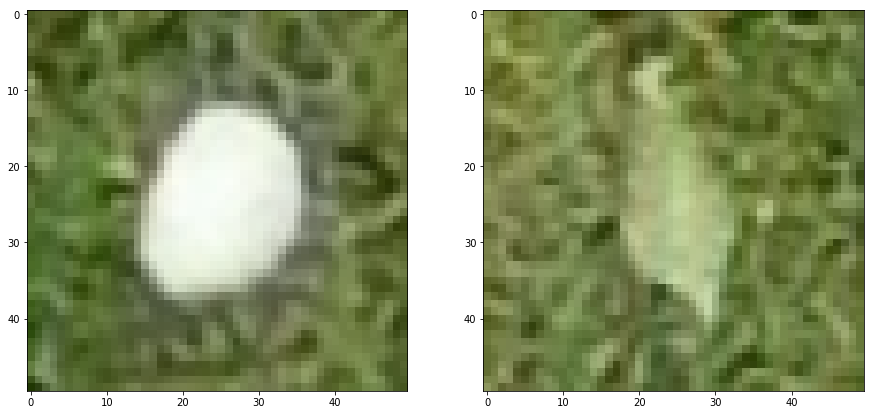

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(hd_p2['img'][5205])
ax2.imshow(hd_p1['img'][3751])

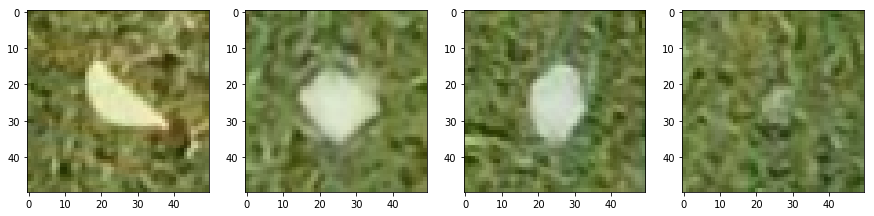

In [51]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,15))
ax1.imshow(hail_dict_part2['img'][2939])
ax2.imshow(hail_dict_part2['img'][3974])
ax3.imshow(hail_dict_part2['img'][5656])
ax4.imshow(hail_dict_part2['img'][3250])

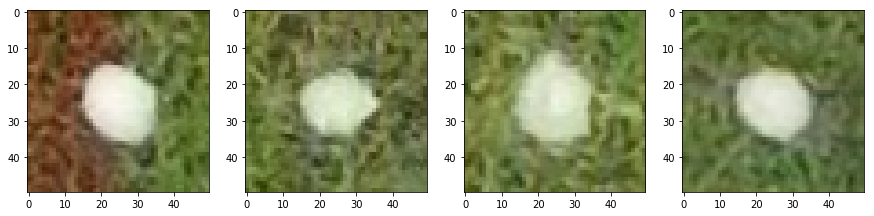

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,15))
ax1.imshow(hail_dict_part3['img'][193])
ax2.imshow(hail_dict_part3['img'][371])
ax3.imshow(hail_dict_part3['img'][936])
ax4.imshow(hail_dict_part3['img'][1075])

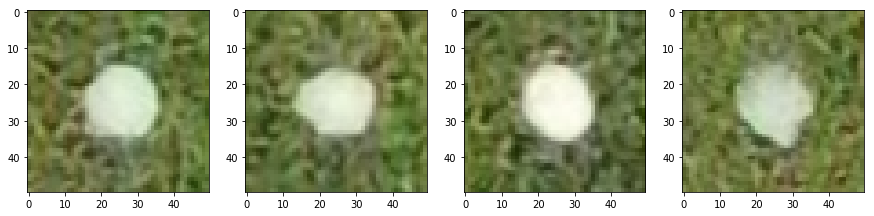

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,15))
ax1.imshow(hail_dict_part3['img'][1223])
ax2.imshow(hail_dict_part3['img'][3092])
ax3.imshow(hail_dict_part3['img'][3495])
ax4.imshow(hail_dict_part3['img'][5035])

In [27]:
print(hd_p2['hail_co'][0][3250])
print(hd_p2['hail_co'][1][3250])

17996
11829


In [ ]:
#List of indexes which are no hail:
no_hail_part1 = [3751] # leaves etc.
no_hail_part2 = [2939, 3250, ]

In [ ]:
#Detectron2 - Real hail 20210620 - Test dataset ML procsessing

in_path_pkl = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/pkl/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

path_detection_edge = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/detection_ml/edge/'
path_detection_mask = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/detection_ml/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/detection_ml/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_ml/'

#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_lai/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_mon/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_wod/'

#out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

hail_dict = process_hail(1.5, 100, in_path_pkl, in_path_ortho, 
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Detectron2 - Real hail 20210620 - Test dataset lai annotations procsessing
in_path_pkl = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/pkl/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

path_detection_edge = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/detection/edge/'
path_detection_mask = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/detection/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/detection/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/hail_sizes/'

#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_lai/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_mon/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_wod/'

#out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

hail_dict_lai = process_hail(1.5, 100, in_path_pkl, in_path_ortho, 
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Detectron2 - Real hail 20210620 - Test dataset wod annotations procsessing
in_path_pkl = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/pkl/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

#path_detection_edge = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/detection/edge/'
path_detection_edge = None
path_detection_mask = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/detection/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/detection/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/hail_sizes/'

#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_lai/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_mon/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_wod/'

#out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

hail_dict_wod = process_hail(1.5, 100, in_path_pkl, in_path_ortho, 
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [ ]:
#Detectron2 - Real hail 20210620 - Test dataset mon annotations procsessing
in_path_pkl = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/pkl/'
in_path_ortho = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/odm_orthophoto_croped.png'

#path_detection_edge = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/detection/edge/'
path_detection_edge = None
path_detection_mask = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/detection/mask/'
path_rgb_img = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/detection/rgb/'

hd_out_path = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/hail_sizes/'

#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_lai/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_mon/'
#hd_out_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/test/hail_sizes_wod/'

#out_file_CNN = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/CNN_hail_centers.png'

hail_dict_mon = process_hail(1.5, 100, in_path_pkl, in_path_ortho, 
                         path_detection_edge, path_detection_mask, path_rgb_img, hd_out_path,
                         use_shape_factor=False, overplot_ortho=False, out_file_CNN=False
                         )

In [2]:
hd_lai = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/hail_sizes/hail_dict.pkl'
hd_mon = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/hail_sizes/hail_dict.pkl'
hd_wod = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/hail_sizes/hail_dict.pkl'
hd_model = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/hail_20210620_r1/test/hail_sizes_ml/hail_dict.pkl'

with open(hd_model,'rb') as f:
    hd_dict = pk.load(f)

with open(hd_lai,'rb') as f:
    hd_dict_lai = pk.load(f)
    
with open(hd_mon,'rb') as f:
    hd_dict_mon = pk.load(f)
    
with open(hd_wod,'rb') as f:
    hd_dict_wod = pk.load(f)

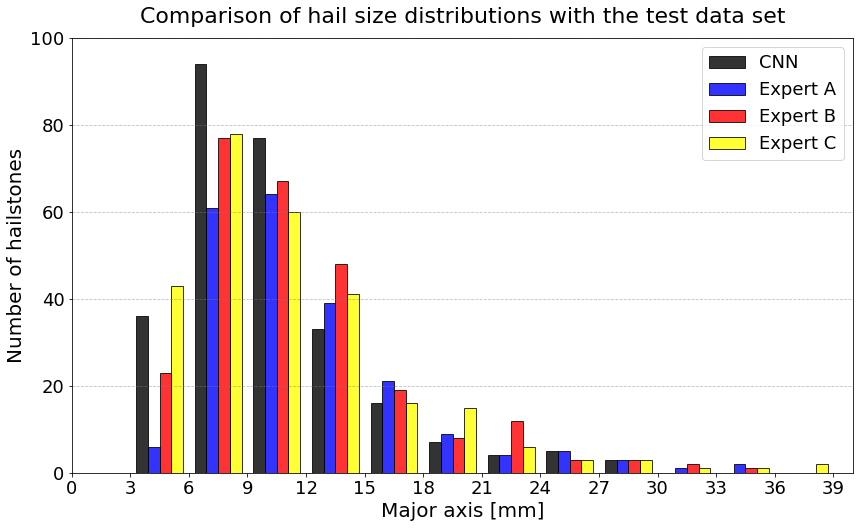

In [3]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
        
#Plot real distribution of test dataset man vs machine
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


n_hail_ml = np.size(hd_dict['major_ma'])
n_hail_lai = np.size(hd_dict_lai['major_ma'])
n_hail_mon = np.size(hd_dict_mon['major_ma'])
n_hail_wod = np.size(hd_dict_wod['major_ma'])

fig, ax = plt.subplots(figsize=[14,8])
#fig.patch.set_facecolor('xkcd:mint green')
numBins = 14
bins = ax.hist([hd_dict['major_ma'],hd_dict_lai['major_ma'], hd_dict_mon['major_ma'], hd_dict_wod['major_ma']],numBins,range=[3,45],color=['black','blue','red','yellow'],alpha=0.8, edgecolor='black',label=['CNN','Expert A','Expert B','Expert C'])

#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
#plt.title('HSD comparison with the test data set of the 2021-06-20 hail event. #Hail: '+str(n_hail_ml)+'|'+str(n_hail_lai)+'|'+str(n_hail_mon)+'|'+str(n_hail_wod),fontsize=20,pad=15)
plt.title('Comparison of hail size distributions with the test data set',fontsize=22,pad=15)
plt.ylim([0,100])
plt.xlim([0,40])
plt.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
plt.xticks(np.linspace(0,39,14))
plt.ylabel('Number of hailstones')
plt.xlabel('Major axis [mm]')
plt.legend(loc='upper right')
plt.savefig(plot_dir+'Comparison_test_distribution_major_mask_REV.png',dpi=400,bbox_inches='tight',facecolor='white')
plt.show()

In [8]:
print(np.median(hd_dict['major_ma']))
print(np.median(hd_dict_lai['major_ma']))
print(np.median(hd_dict_mon['major_ma']))
print(np.median(hd_dict_wod['major_ma']))

9.0
10.5
9.0
9.0


In [5]:
hd_part1 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/hail_sizes/part1/hail_dict.pkl'
hd_part2 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/hail_sizes/part2/hail_dict.pkl'
hd_part3 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/all_images/hail_sizes/part3/hail_dict.pkl'

#List of indexes which are no hail:
no_hail_part1 = [3751] # leaves etc.
no_hail_part2 = [2939, 3250]

with open(hd_part1,'rb') as f:
    hd_p1 = pk.load(f)

for ind in no_hail_part1:
    hd_p1['major_ma'][ind] = np.nan
    hd_p1['minor_ma'][ind] = np.nan
    hd_p1['L_center'][ind] = np.nan    
    
with open(hd_part2,'rb') as f:
    hd_p2 = pk.load(f)

for ind in no_hail_part2:
    hd_p2['major_ma'][ind] = np.nan
    hd_p2['minor_ma'][ind] = np.nan
    hd_p2['L_center'][ind] = np.nan    
    
with open(hd_part3,'rb') as f:
    hd_p3 = pk.load(f)
    
ds = [hd_p1, hd_p2, hd_p3]
d = {}
for k in ['L_center', 'major_ma', 'minor_ma','hail_co','tile_names','img']:
    d[k] = tuple(d[k] for d in ds)

L_center = np.hstack(np.asarray(d['L_center'][:]))
major_ax = np.hstack(np.asarray(d['major_ma'][:]))
minor_ax =  np.hstack(np.asarray(d['minor_ma'][:]))
names = np.hstack(np.asarray(d['tile_names'][:]))

In [6]:
hail_co_x = np.hstack([d['hail_co'][0][0],d['hail_co'][1][0],d['hail_co'][2][0]])
hail_co_y = np.hstack([d['hail_co'][0][1],d['hail_co'][1][1],d['hail_co'][2][1]])

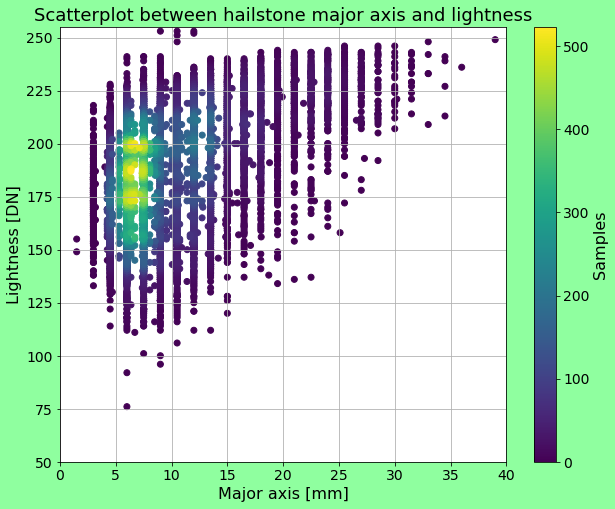

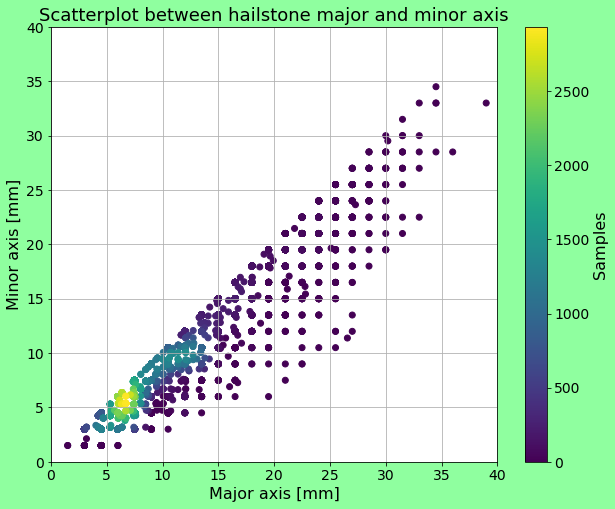

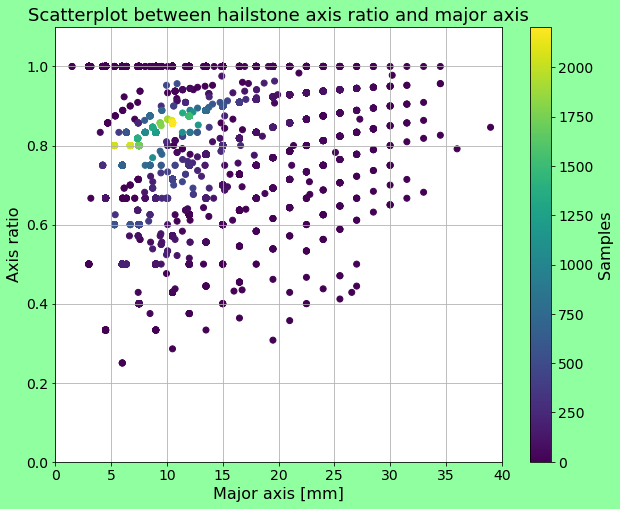

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

#Plot real distribution of test dataset human vs machine
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def density_scatter( x , y, xlim, ylim, title, xlab, ylab, density, ax = None, sort = True, bins = 30, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=[10,8])
        fig.patch.set_facecolor('xkcd:mint green')
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = density )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ma = ax.scatter( x, y, c=z, **kwargs )
    
    #if density == True:
        #norm = Normalize(vmin = np.min(z), vmax = np.max(z))
        #cbar = fig.colorbar(ma, norm = norm, cmap='viridis', ax=ax)
    #else:
    cbar = fig.colorbar(ma, cmap='viridis', ax=ax)
        
    if density == False:
        cbar.ax.set_ylabel('Samples')
    else:
        cbar.ax.set_ylabel('Density')
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title, size=18)
    plt.ylabel(ylab)
    plt.xlabel(xlab)

    return ax


if "__main__" == __name__ :
    xlim = [0,40]
    ylim = [50,255]
    title='Scatterplot between hailstone major axis and lightness'
    xlab = 'Major axis [mm]'
    ylab = 'Lightness [DN]'
    x = major_ax[~np.isnan(major_ax)]
    y = L_center[~np.isnan(L_center)]
    density_scatter( x, y, xlim, ylim, title, xlab, ylab, density=False, bins = [18,41], vmin=0)
    plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/'
    plt.savefig(plot_dir+'Scatterplot_major_ma_vs_lightness.png',dpi=300,bbox_inches='tight',facecolor='xkcd:mint green')
    
    xlim = [0,40]
    ylim = [0,40]
    title='Scatterplot between hailstone major and minor axis'
    xlab = 'Major axis [mm]'
    ylab = 'Minor axis [mm]'
    x = major_ax[~np.isnan(major_ax)]
    y = minor_ax[~np.isnan(minor_ax)]
    density_scatter( x, y, xlim, ylim, title, xlab, ylab, density=False, bins = [18,18], vmin=0)
    plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/'
    plt.savefig(plot_dir+'Scatterplot_major_ma_vs_minor_ma.png',dpi=300,bbox_inches='tight',facecolor='xkcd:mint green')
    
    xlim = [0,40]
    ylim = [0,1.1]
    title='Scatterplot between hailstone axis ratio and major axis'
    xlab = 'Major axis [mm]'
    ylab = 'Axis ratio'
    x = major_ax[~np.isnan(major_ax)]
    y = minor_ax[~np.isnan(minor_ax)] / major_ax[~np.isnan(major_ax)]
    density_scatter( x, y, xlim, ylim, title, xlab, ylab, density=False, bins = [10,18], vmin=0)
    plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/'
    plt.savefig(plot_dir+'Scatterplot_major_ma_vs_ratio.png',dpi=300,bbox_inches='tight',facecolor='xkcd:mint green')
    

In [31]:
hd_p2.keys()

dict_keys(['minor_ma', 'tile_names', 'major_ma', 'hail_co', 'L_center', 'img', 'minor_ed', 'gsd', 'tile_co', 'edge_co', 'img_mask_sect', 'major_ed'])

In [ ]:
#Plot histogram of aspect ratio

In [45]:
import shutil

p1 = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/all_images/pkl/part3/'
path_cp = '/home/martin/container/autofs/data/hail/detectron2/products/hparam_tuning/run-3/erad/'

i30 = np.where(major_ax >= 30)

for ind in i30[0]:
    name = names[ind]
    try:
        shutil.copy(p1+'mask_array_'+name[0:21]+'.pkl', path_cp)
    except:
        continue

/home/martin/anaconda3/envs/hail/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


In [60]:
import shutil
i30 = np.where(np.asarray(hail_dict_erad['major_ma']) >= 30)

path_all = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/detection/edge/'
path_cp = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/erad/detection/edge/i30/'

if not os.path.exists(path_cp):
    os.makedirs(path_cp)

for ind in i30[0]:
    #print(ind)
    x = hail_dict_erad['hail_co'][0][ind]
    y = hail_dict_erad['hail_co'][1][ind]
    shutil.copy(path_all+'hail_x'+str(x)+'_y'+str(y)+'_ed.png', path_cp)

In [68]:
i30

(array([  1,  10,  17,  21,  26,  43,  55,  62,  72,  81,  98, 110, 122,
        140, 151, 163, 173, 186, 196, 204, 205, 208, 219, 227, 245, 251,
        254, 261, 272, 278, 295, 305, 315, 324, 336, 347, 359, 370, 378,
        387, 394, 407, 428, 439, 448, 459]),)

In [69]:
for i in i30[0]:
    cv2.imwrite('hail_'+str(i)+'.png',hail_dict_erad['img'][i])